In [1]:
#libraries
import numpy as np 
import pandas as pd 
import os
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
#import lightgbm as lgb
#import xgboost as xgb
import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import gc
import plotly

import warnings
warnings.filterwarnings("ignore")

import logging

logging.basicConfig(filename='log.txt',level=logging.DEBUG, format='%(asctime)s %(message)s')


In [2]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [4]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [5]:
retained_columns = numerical_columns + categorical_columns

%time
df_train = pd.read_csv('data/microsoft-malware-prediction/train.csv',usecols = retained_columns,dtype = dtypes)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


In [6]:
df_train = reduce_mem_usage(df_train)

Mem. usage decreased to 2363.03 Mb (0.0% reduction)


In [7]:
df_train.describe()

,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,...,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
count,8.921483e+06,8889165.0,8.921483e+06,433438.0,8.885262e+06,8885262.0,8885262.0,8.921483e+06,8.921483e+06,8.596074e+06,...,8.761350e+06,8.921483e+06,3.261780e+06,8.905530e+06,8.921483e+06,8.921483e+06,8850140.0,8618032.0,8618032.0,8.921483e+06
mean,7.509962e-06,NaN,1.733378e-02,NaN,4.948320e+04,NaN,NaN,9.879711e-01,1.080490e+02,8.049152e+04,...,3.268055e+04,4.860229e-01,2.980232e-07,7.202148e-03,1.255431e-01,3.807091e-02,NaN,NaN,NaN,4.997927e-01
std,2.740421e-03,0.0,1.305118e-01,NaN,1.379994e+04,0.0,0.0,1.090149e-01,6.304706e+01,4.873461e+04,...,2.112612e+04,4.998046e-01,5.459785e-04,8.453369e-02,3.313338e-01,1.913675e-01,0.0,0.0,0.0,5.000000e-01
min,0.000000e+00,0.0,0.000000e+00,1.0,3.000000e+00,0.0,0.0,0.000000e+00,1.000000e+00,5.000000e+00,...,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,1.0,0.000000e+00
25%,0.000000e+00,7.0,0.000000e+00,788.0,4.948000e+04,1.0,1.0,1.000000e+00,5.100000e+01,3.682500e+04,...,1.315600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,3.0,0.000000e+00
50%,0.000000e+00,7.0,0.000000e+00,1632.0,5.344700e+04,1.0,1.0,1.000000e+00,9.700000e+01,8.237300e+04,...,3.307000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,10.0,0.000000e+00
75%,0.000000e+00,7.0,0.000000e+00,2372.0,5.344700e+04,2.0,1.0,1.000000e+00,1.620000e+02,1.237000e+05,...,5.243600e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,11.0,1.000000e+00
max,1.000000e+00,35.0,1.000000e+00,3212.0,7.050700e+04,7.0,5.0,1.000000e+00,2.220000e+02,1.679620e+05,...,7.210500e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,1.0,15.0,1.000000e+00


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8921483 entries, 0 to 8921482
Data columns (total 83 columns):
 #   Column                                             Dtype   
---  ------                                             -----   
 0   MachineIdentifier                                  category
 1   ProductName                                        category
 2   EngineVersion                                      category
 3   AppVersion                                         category
 4   AvSigVersion                                       category
 5   IsBeta                                             int8    
 6   RtpStateBitfield                                   float16 
 7   IsSxsPassiveMode                                   int8    
 8   DefaultBrowsersIdentifier                          float16 
 9   AVProductStatesIdentifier                          float32 
 10  AVProductsInstalled                                float16 
 11  AVProductsEnabled                    

In [9]:
df_train.shape

(8921483, 83)

In [10]:
print (df_train.HasDetections)

0          0
1          0
2          0
3          1
4          1
          ..
8921478    1
8921479    0
8921480    1
8921481    1
8921482    0
Name: HasDetections, Length: 8921483, dtype: int8


In [11]:
# special thanks to https://www.kaggle.com/artgor/is-this-malware-eda-fe-and-lgb-updated

stats = []
for col in df_train.columns:
    stats.append((col, df_train[col].dtype, df_train[col].nunique(), df_train[col].isnull().sum() * 100 / df_train.shape[0], df_train[col].value_counts(normalize=True, dropna=False).values[0] * 100))
    
stats_df = pd.DataFrame(stats, columns=['Feature', "type", 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category'])

stats_df.sort_values(by = 'Percentage of missing values', ascending=False)

,Feature,type,Unique_values,Percentage of missing values,Percentage of values in the biggest category
28,PuaMode,category,2,99.974119,99.974119
41,Census_ProcessorClass,category,3,99.589407,99.589407
8,DefaultBrowsersIdentifier,float16,1730,95.141637,95.141637
68,Census_IsFlightingInternal,float16,2,83.044030,83.044030
52,Census_InternalBatteryType,category,78,71.046809,71.046809
...,...,...,...,...,...
1,ProductName,category,6,0.000000,98.935569
45,Census_HasOpticalDiskDrive,int8,2,0.000000,92.281272
54,Census_OSVersion,category,469,0.000000,15.845202
55,Census_OSArchitecture,category,3,0.000000,90.858045


In [12]:
stats_df.sort_values(by = 'Percentage of values in the biggest category', ascending=False).head(15)

,Feature,type,Unique_values,Percentage of missing values,Percentage of values in the biggest category
5,IsBeta,int8,2,0.000000,99.999249
27,AutoSampleOptIn,int8,2,0.000000,99.997108
28,PuaMode,category,2,99.974119,99.974119
65,Census_IsPortableOperatingSystem,int8,2,0.000000,99.945480
35,Census_DeviceFamily,category,3,0.000000,99.838256
41,Census_ProcessorClass,category,3,99.589407,99.589407
33,UacLuaenable,float32,11,0.121482,99.271803
76,Census_IsVirtualDevice,float16,2,0.178816,99.118499
1,ProductName,category,6,0.000000,98.935569
12,HasTpm,int8,2,0.000000,98.797106


In [13]:
good_cols = list(df_train.columns)
na_rate_threshold = 0.7
unbalanced_feature_rate_threshold = 0.98

for col in df_train.columns:
    
    # remove columns with high NA rate
    na_rate = df_train[col].isnull().sum() / df_train.shape[0]
    
    # remove columns with high Unbalanced values rate
    unbalanced_rate = df_train[col].value_counts(normalize=True, dropna=False).values[0]
    
    if na_rate > na_rate_threshold:
        good_cols.remove(col)
    elif unbalanced_rate > unbalanced_feature_rate_threshold:
        good_cols.remove(col)

In [14]:
good_cols

['MachineIdentifier',
 'EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'RtpStateBitfield',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Processor',
 'OsVer',
 'OsBuild',
 'OsSuite',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'IsProtected',
 'SMode',
 'IeVerIdentifier',
 'SmartScreen',
 'Firewall',
 'Census_MDC2FormFactor',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_PrimaryDiskTypeName',
 'Census_SystemVolumeTotalCapacity',
 'Census_HasOpticalDiskDrive',
 'Census_TotalPhysicalRAM',
 'Census_ChassisTypeName',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDi

In [15]:
df_train = df_train[good_cols]

In [16]:
df_train.shape

(8921483, 68)

In [17]:
df_train['HasDetections'].value_counts()

0    4462591
1    4458892
Name: HasDetections, dtype: int64

In [18]:
detection_yes = (df_train['HasDetections'] == 0).sum()
detection_no = (df_train['HasDetections'] == 1).sum()


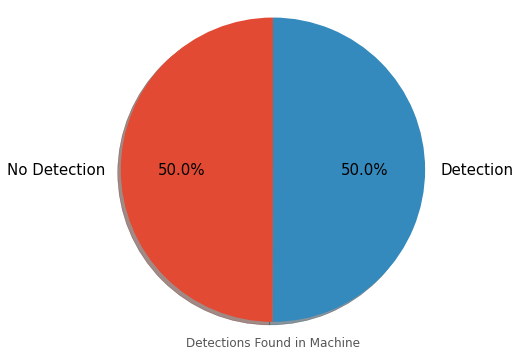

<Figure size 432x288 with 0 Axes>

In [19]:
labels = 'No Detection', 'Detection',
sizes = [detection_no, detection_yes]

fig1, ax1 = plt.subplots(figsize=(6,6))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',shadow=True, startangle=90, textprops={'fontsize': 15})
ax1.axis('equal')
ax1.set_xlabel('Detections Found in Machine')
plt.show()
plt.savefig("data/detections.svg")

In [20]:
categorical_columns = list(df_train.loc[:, df_train.dtypes =="category"].columns)
numerical_and_binary_columns = list(df_train.loc[:, df_train.dtypes !="category"].columns)
numerical_columns = list(numerical_and_binary_columns)

categorical_columns.remove("MachineIdentifier")

binary_columns = []
count = 0
for col in numerical_and_binary_columns:
   # print(col, df_train[col].nunique())
   # count += 1
    if df_train[col].nunique() == 2:
        binary_columns.append(col)
        numerical_columns.remove(col)

In [21]:
categorical_columns

['EngineVersion',
 'AppVersion',
 'AvSigVersion',
 'Platform',
 'Processor',
 'OsVer',
 'OsPlatformSubRelease',
 'OsBuildLab',
 'SkuEdition',
 'SmartScreen',
 'Census_MDC2FormFactor',
 'Census_PrimaryDiskTypeName',
 'Census_ChassisTypeName',
 'Census_PowerPlatformRoleName',
 'Census_OSVersion',
 'Census_OSArchitecture',
 'Census_OSBranch',
 'Census_OSEdition',
 'Census_OSSkuName',
 'Census_OSInstallTypeName',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_GenuineStateName',
 'Census_ActivationChannel',
 'Census_FlightRing']

In [22]:
binary_columns

['IsProtected',
 'SMode',
 'Firewall',
 'Census_HasOpticalDiskDrive',
 'Census_ThresholdOptIn',
 'Census_IsSecureBootEnabled',
 'Census_IsWIMBootEnabled',
 'Census_IsTouchEnabled',
 'Census_IsPenCapable',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Wdft_IsGamer',
 'HasDetections']

In [23]:
numerical_columns

['RtpStateBitfield',
 'AVProductStatesIdentifier',
 'AVProductsInstalled',
 'AVProductsEnabled',
 'CountryIdentifier',
 'CityIdentifier',
 'OrganizationIdentifier',
 'GeoNameIdentifier',
 'LocaleEnglishNameIdentifier',
 'OsBuild',
 'OsSuite',
 'IeVerIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OEMModelIdentifier',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ProcessorModelIdentifier',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_InternalBatteryNumberOfCharges',
 'Census_OSBuildNumber',
 'Census_OSBuildRevision',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Wdft_RegionIdentifier']

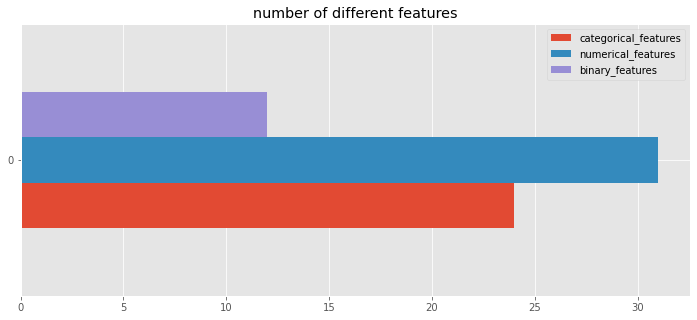

In [24]:
categories_list = []
categories_list.append(len(categorical_columns))
categories_list.append(len(numerical_columns))
categories_list.append(len(binary_columns))

categories_df = pd.DataFrame(categories_list, 
                             index=["categorical_features", "numerical_features", "binary_features"])

categories_df = categories_df.transpose().plot(kind="barh", figsize=(12, 5), title="number of different features")

In [25]:
df_train.shape

(8921483, 68)

## Feature Engineering

In [26]:
df_train.head(5)

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,...,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,7.0,53447.0,1.0,1.0,29,128035.0,...,628.0,36144.0,0,NaN,0,0,0.0,0.0,10.0,0
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,7.0,53447.0,1.0,1.0,93,1482.0,...,628.0,57858.0,0,NaN,0,0,0.0,0.0,8.0,0
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,7.0,53447.0,1.0,1.0,86,153579.0,...,142.0,52682.0,0,NaN,0,0,0.0,0.0,3.0,0
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,7.0,53447.0,1.0,1.0,88,20710.0,...,355.0,20050.0,0,NaN,0,0,0.0,0.0,3.0,1
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,7.0,53447.0,1.0,1.0,18,37376.0,...,355.0,19844.0,0,0.0,0,0,0.0,0.0,1.0,1


In [27]:
#AppVersion2 indicates whether your Windows Defender is up to date. This is the second number from AppVersion. 
#Regardless of your operating system and version, you can always have AppVersion with second number equal 18. 
#For example, you should have 4.18.1807.18075 instead of 4.12.xx.xx

#DriveA is the ratio of harddrive partition used for the operating system with the total hard drive. 
#Savy users install multiple operating systems. Savy users have reduced HasDetections.

#OSBuildLab1 is the specific type of architecture the OS is catered for. E.g. amd64 vs X86

In [28]:
# ENGINEERED FEATURE 1
df_train['AppVersion2'] = df_train['AppVersion'].map(lambda x: np.int(x.split('.')[1]))
#df_test['AppVersion2'] = df_test['AppVersion'].map(lambda x: np.int(x.split('.')[1]))

# ENGINEERED FEATURE 2
df_train['DriveA'] = df_train['Census_SystemVolumeTotalCapacity'].astype('float')/df_train['Census_PrimaryDiskTotalCapacity'].astype('float')
df_train['DriveA'] = df_train['DriveA'].astype('float32') 
#df_test['DriveA'] = df_test['Census_SystemVolumeTotalCapacity'].astype('float')/df_test['Census_PrimaryDiskTotalCapacity'].astype('float')
#df_test['DriveA'] = df_test['DriveA'].astype('float32')

# ENGINEERED FEATURE 3
new = df_train["OsBuildLab"].str.split(".", expand = True)
df_train["OsBuildLab1"] = new[2]
#new = test["OsBuildLab"].str.split(".", expand = True)
#df_test["OsBuildLab1"] = new[2]


categorical_columns.append("AppVersion2")
categorical_columns.append("OsBuildLab1")
numerical_and_binary_columns.append("DriveA")

In [29]:
df_train.head(5)

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,...,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,AppVersion2,DriveA,OsBuildLab1
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,7.0,53447.0,1.0,1.0,29,128035.0,...,NaN,0,0,0.0,0.0,10.0,0,18,0.627859,amd64fre
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,7.0,53447.0,1.0,1.0,93,1482.0,...,NaN,0,0,0.0,0.0,8.0,0,13,0.214671,amd64fre
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,7.0,53447.0,1.0,1.0,86,153579.0,...,NaN,0,0,0.0,0.0,3.0,0,18,0.995056,amd64fre
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,7.0,53447.0,1.0,1.0,88,20710.0,...,NaN,0,0,0.0,0.0,3.0,1,18,0.952368,amd64fre
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,7.0,53447.0,1.0,1.0,18,37376.0,...,0.0,0,0,0.0,0.0,1.0,1,18,0.213654,amd64fre


In [30]:
#Replace Nan values with the mode values in each column

#for col in df_train.columns:
#    df_train[col] = np.where(df_train[col].isnull(), df_train[col].mode()[0], df_train[col])
    
for column in df_train.columns:
    df_train[column].fillna(df_train[column].mode()[0], inplace=True) 

elapsed time: 76.99860882759094 seconds


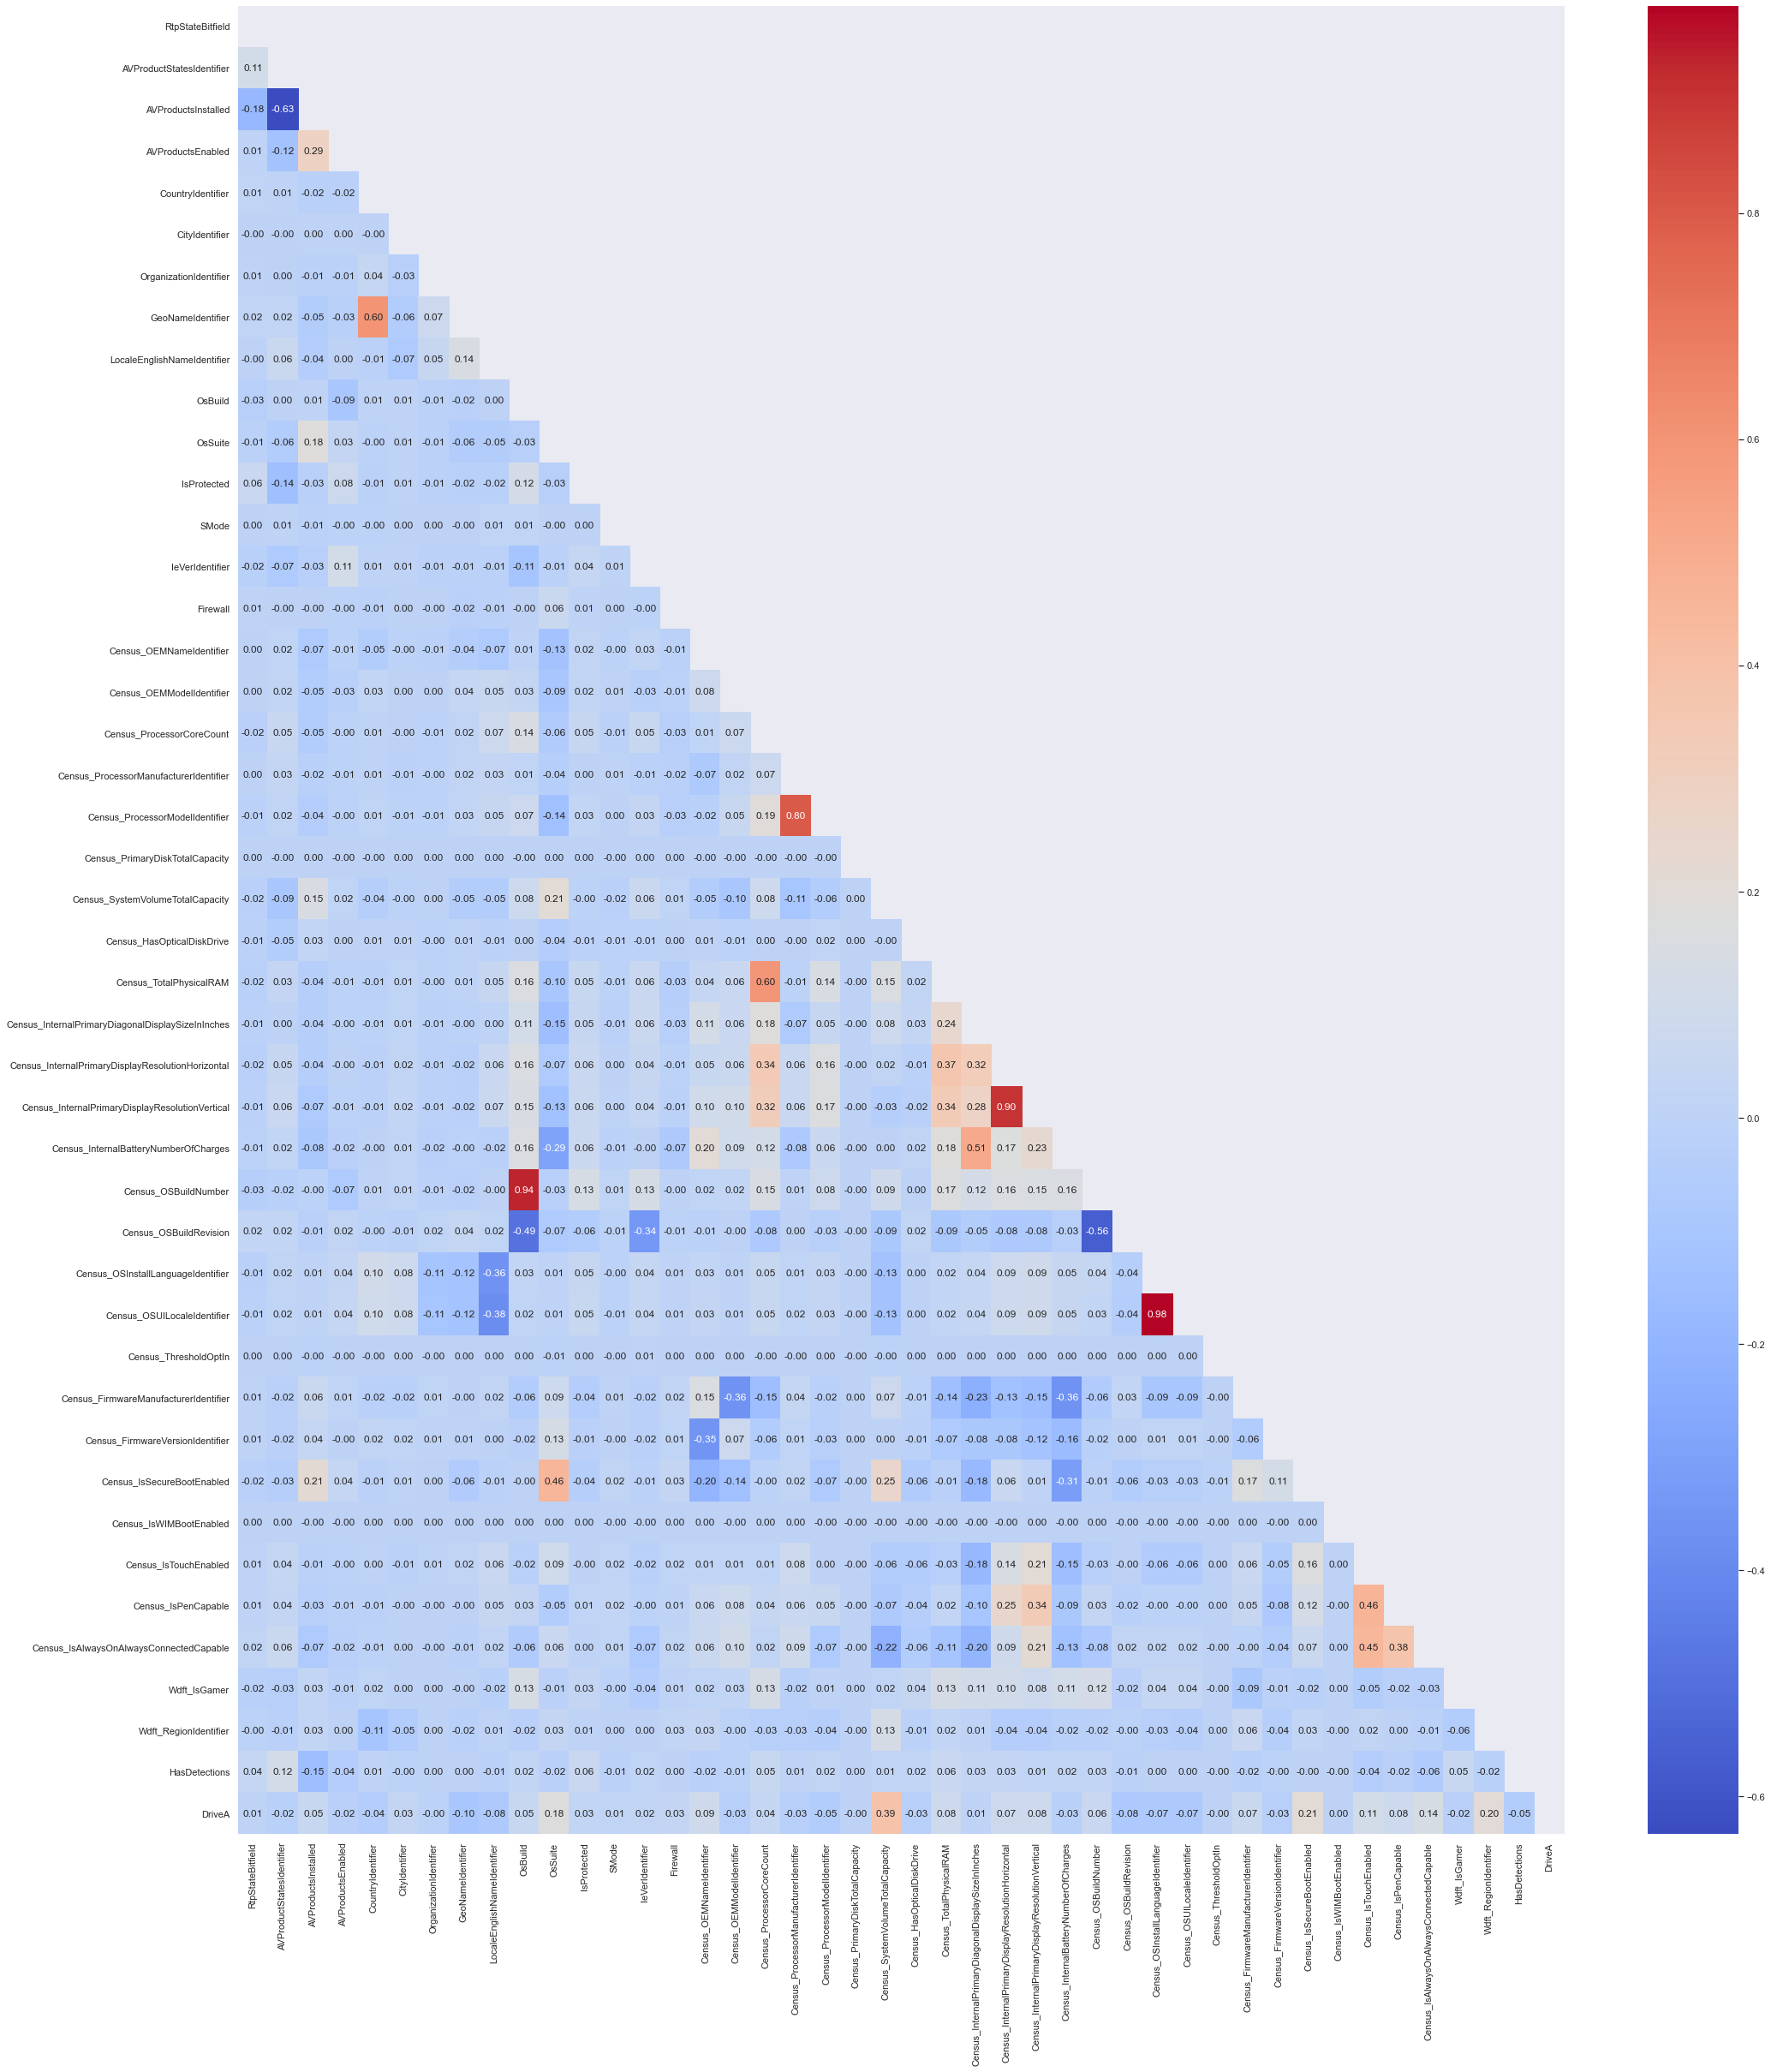

In [31]:
start_time = time.time()

sns.set(rc={'figure.figsize':(34.7,39.27)})

# Compute the correlation matrix
corr = df_train[numerical_and_binary_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')

print("elapsed time:", time.time() - start_time, "seconds")

## Drop columns to prevent multicollinearity

In [32]:
#Removing features that have more than 0.60 in collinearity with other features
df_train = df_train.drop(['OsBuild','Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_OSInstallLanguageIdentifier',
                         'Census_ProcessorModelIdentifier', 'Census_TotalPhysicalRAM', 'GeoNameIdentifier' ],axis=1)
#improve validation score
#CE = ['CountryIdentifier', 'SkuEdition', 'Firewall', 'Census_ProcessorCoreCount', 'Census_OSUILocaleIdentifier', 'Census_FlightRing'

In [33]:
df_train.head(5)

,MachineIdentifier,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,CountryIdentifier,CityIdentifier,...,Census_IsWIMBootEnabled,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections,AppVersion2,DriveA,OsBuildLab1
0,0000028988387b115f69f31a3bf04f09,1.1.15100.1,4.18.1807.18075,1.273.1735.0,7.0,53447.0,1.0,1.0,29,128035.0,...,0.0,0,0,0.0,0.0,10.0,0,18,0.627859,amd64fre
1,000007535c3f730efa9ea0b7ef1bd645,1.1.14600.4,4.13.17134.1,1.263.48.0,7.0,53447.0,1.0,1.0,93,1482.0,...,0.0,0,0,0.0,0.0,8.0,0,13,0.214671,amd64fre
2,000007905a28d863f6d0d597892cd692,1.1.15100.1,4.18.1807.18075,1.273.1341.0,7.0,53447.0,1.0,1.0,86,153579.0,...,0.0,0,0,0.0,0.0,3.0,0,18,0.995056,amd64fre
3,00000b11598a75ea8ba1beea8459149f,1.1.15100.1,4.18.1807.18075,1.273.1527.0,7.0,53447.0,1.0,1.0,88,20710.0,...,0.0,0,0,0.0,0.0,3.0,1,18,0.952368,amd64fre
4,000014a5f00daa18e76b81417eeb99fc,1.1.15100.1,4.18.1807.18075,1.273.1379.0,7.0,53447.0,1.0,1.0,18,37376.0,...,0.0,0,0,0.0,0.0,1.0,1,18,0.213654,amd64fre


In [34]:
df_train = df_train.drop(['MachineIdentifier'], axis = 1)

In [35]:
df_train.shape

(8921483, 64)

In [36]:
#LabelEncoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

def MultiLabelEncoder(columnlist,dataframe):
    for i in columnlist:
        #print(i)
        labelencoder_X=LabelEncoder()
        dataframe[i]=labelencoder_X.fit_transform(dataframe[i])

In [37]:
MultiLabelEncoder(categorical_columns, df_train)

## Read the test data

## Now we train with sample size

In [47]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
import time

In [48]:
#train = df_train.sample(n=900000, random_state=42)

In [49]:
# We use simple validation to create our train/validation/test split
# This will become particularly important as we calculate our error metrics

X, y = df_train.drop('HasDetections',axis=1), df_train['HasDetections']

# hold out 20% of the data for final testing
X_train_val , X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=10)
# hold out another 20% of the data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=3)

scaler = StandardScaler()

X_train_val_scaled = scaler.fit_transform(X_train.values)
#X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

In [50]:
#from lightgbm import LGBMClassifier

#lgbm = LGBMClassifier()
#gridParams = {
#            'learning_rate': [0.005, 0.01],
#            'n_estimators': [8,16,24],
#            'num_leaves': [6,12,18], # large num_leaves helps improve accuracy but might lead to over-fitting
#            'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
#            'objective' : ['binary'],
#            'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
#            'random_state' : [500],
#            'colsample_bytree' : [0.64, 0.65, 0.66],
#            'subsample' : [0.7,0.75],
#            'reg_alpha' : [1,1.2],
#            'reg_lambda' : [1,1.2,1.4],}

#CVModeling(lgbm, gridParams,X_train,y_train)

In [51]:
from lightgbm import LGBMClassifier

lgbmodel = LGBMClassifier(n_estimators=3000, colsample_bytree=0.2, objective='binary', num_leaves=20,
          max_depth=-1, learning_rate=0.05,num_iterations = 10000, max_bin = 500, boosting_type = 'gbdt')
%timeit
lgbmodel.fit(X_train, y_train, eval_metric='auc',
          eval_set=[(X_val, y_val)], verbose=250,
          early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[250]	valid_0's auc: 0.707918	valid_0's binary_logloss: 0.620936
[500]	valid_0's auc: 0.715283	valid_0's binary_logloss: 0.614781
[750]	valid_0's auc: 0.718769	valid_0's binary_logloss: 0.612204
[1000]	valid_0's auc: 0.721048	valid_0's binary_logloss: 0.610465
[1250]	valid_0's auc: 0.722583	valid_0's binary_logloss: 0.609286
[1500]	valid_0's auc: 0.723859	valid_0's binary_logloss: 0.608305
[1750]	valid_0's auc: 0.725074	valid_0's binary_logloss: 0.607393
[2000]	valid_0's auc: 0.726073	valid_0's binary_logloss: 0.606583
[2250]	valid_0's auc: 0.726808	valid_0's binary_logloss: 0.606012
[2500]	valid_0's auc: 0.727507	valid_0's binary_logloss: 0.605464
[2750]	valid_0's auc: 0.72808	valid_0's binary_logloss: 0.604992
[3000]	valid_0's auc: 0.728618	valid_0's binary_logloss: 0.604562
[3250]	valid_0's auc: 0.729116	valid_0's binary_logloss: 0.604145
[3500]	valid_0's auc: 0.729543	valid_0's binary_logloss: 0.60381
[3750]	valid_0's au

LGBMClassifier(colsample_bytree=0.2, learning_rate=0.05, max_bin=500,
               n_estimators=3000, num_iterations=10000, num_leaves=20,
               objective='binary')

Precision: 52.3992%,   Recall: 98.2963%

F1 score = 68.3584% 


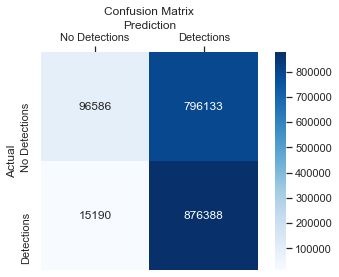

In [85]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve,f1_score, fbeta_score, make_scorer
from sklearn.metrics import confusion_matrix, classification_report

#y_predict = lgbmodel.predict(X_test)
y_predict = (lgbmodel.predict_proba(X_test)[:, 1] >= 0.2)

#print("\nDefault threshold: 0.5")
print("Precision: {:6.4f}%,   Recall: {:6.4f}%".format(100*precision_score(y_test, y_predict), 
                                                     100*recall_score(y_test, y_predict)))

print("\nF1 score = {:6.4f}% ".format(100*f1_score(y_test, y_predict)))


# Print confusion matrix for kNN
f, ax = plt.subplots(figsize=(6, 4))
confusionmatrix = confusion_matrix(y_test, y_predict)
sns.heatmap(confusionmatrix, cmap=plt.cm.Blues, annot=True, square=True,fmt ='g',xticklabels=['No Detections', 'Detections'], yticklabels=['No Detections', 'Detections'])

ax.set_title('Confusion Matrix')
ax.set_ylabel('Actual')
ax.set_xlabel('Prediction')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

plt.savefig('Confusion Matrix.png')

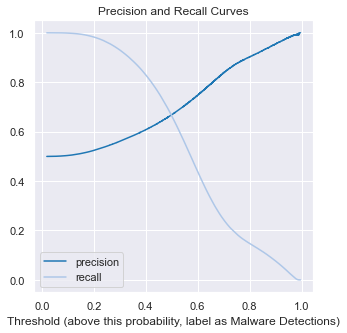

In [86]:
## We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lgbmodel.predict_proba(X_test)[:, 1])

plt.figure(figsize=(5,5))
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as Malware Detections)');
plt.title('Precision and Recall Curves');
plt.savefig('PR_Curve.png')

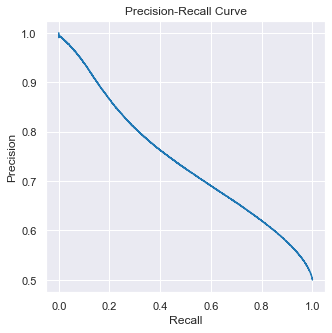

In [87]:
plt.figure(figsize=(5,5))
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");
plt.savefig('PR_Curve_2.png')

In [89]:
# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, lgbmodel.predict_proba(X_test)[:,1])

# Calculate Area under the curve to display on the plot
auc = roc_auc_score(y_test,lgbmodel.predict_proba(X_test)[:,1])

ROC AUC score =  0.7347020665338097


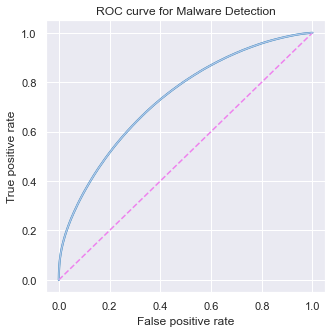

In [92]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Malware Detection');
print("ROC AUC score = ", roc_auc_score(y_test, lgbmodel.predict_proba(X_test)[:,1]))
# Now, plot the computed values
label = 'Light Gradient Boosting Machine - Gradient Boosting Decision Tree'
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (label, auc))
plt.savefig('lgbm_ROC_Curve.png')

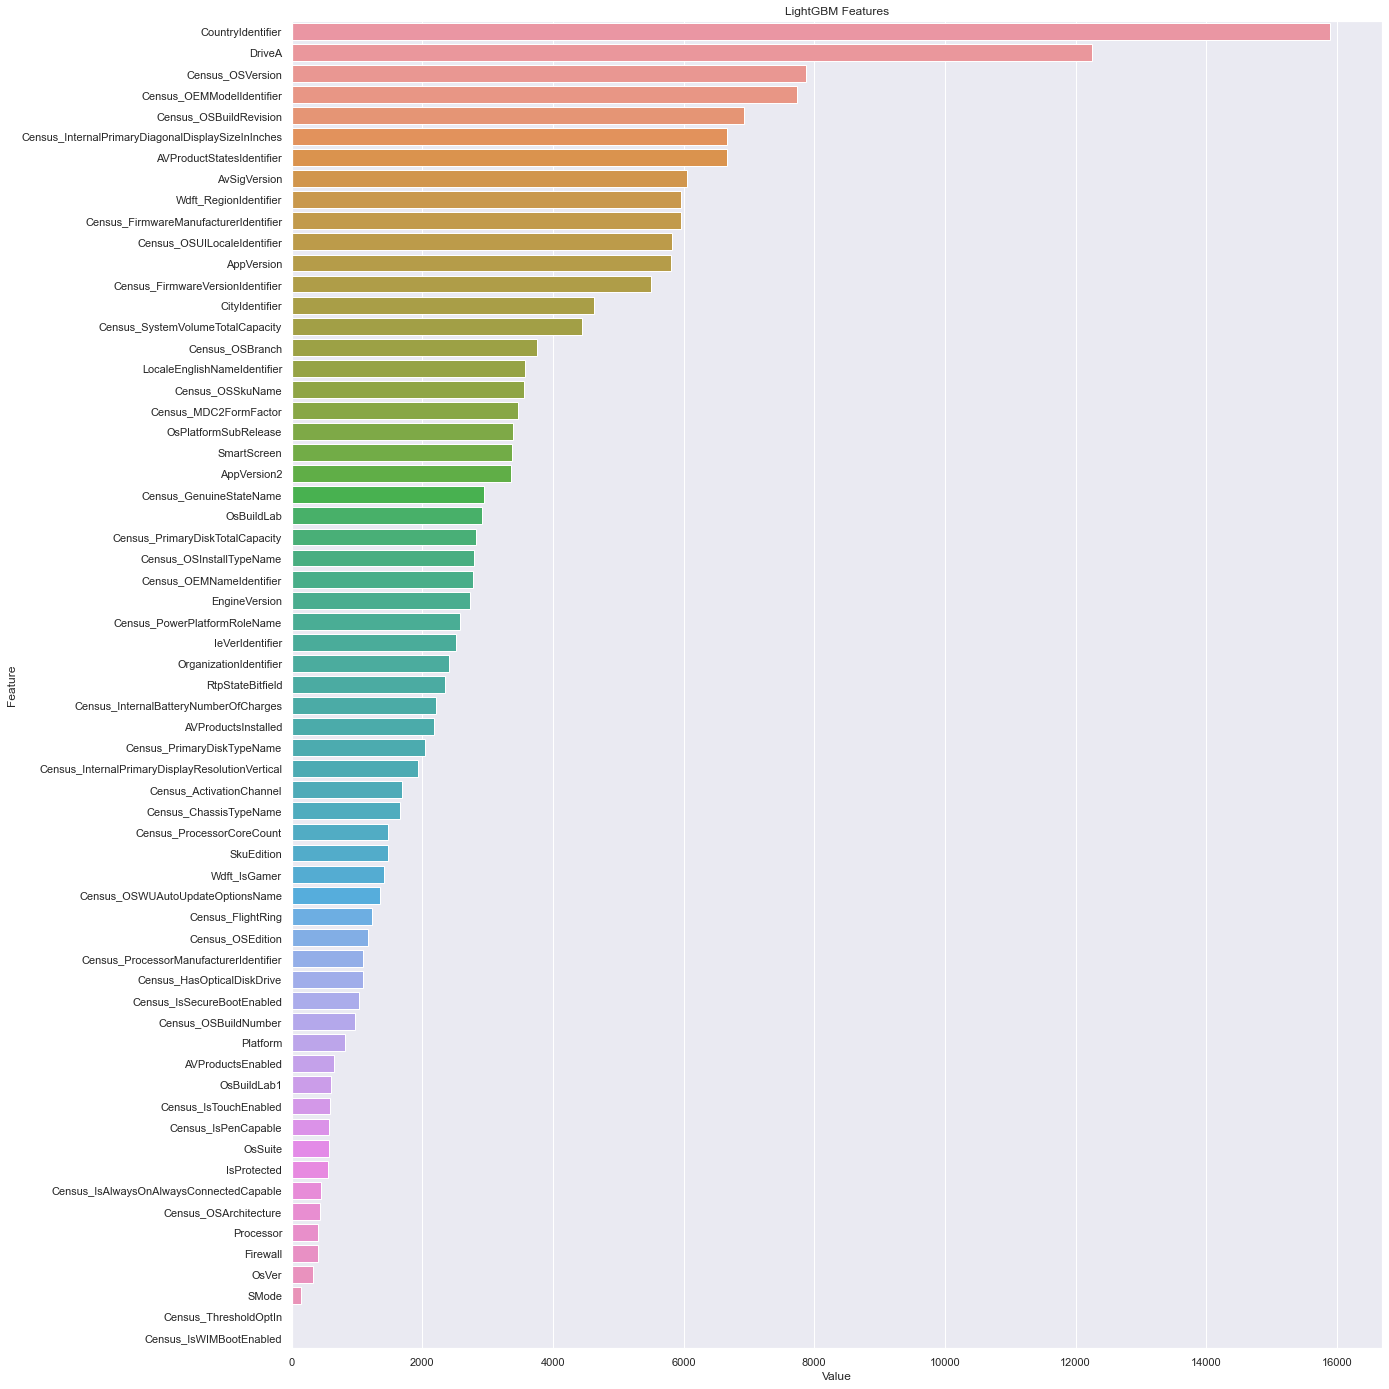

<Figure size 2498.4x2827.44 with 0 Axes>

In [116]:
feature_imp = pd.DataFrame(sorted(zip(lgbmodel.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [58]:
#Check for over fitting. Results should not differ too much
print('Training set score: {:.4f}'.format(lgbmodel.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(lgbmodel.score(X_test, y_test)))

Training set score: 0.6759
Test set score: 0.6677


In [91]:
feature_imp

,Value,Feature
0,0,Census_IsWIMBootEnabled
1,6,Census_ThresholdOptIn
2,139,SMode
3,333,OsVer
4,399,Firewall
...,...,...
58,6923,Census_OSBuildRevision
59,7741,Census_OEMModelIdentifier
60,7877,Census_OSVersion
61,12253,DriveA


In [93]:
top10_feature_imp = feature_imp.sort_values(by="Value", ascending=False).head(10)

In [94]:
top10_feature_imp

,Value,Feature
62,15903,CountryIdentifier
61,12253,DriveA
60,7877,Census_OSVersion
59,7741,Census_OEMModelIdentifier
58,6923,Census_OSBuildRevision
57,6669,Census_InternalPrimaryDiagonalDisplaySizeInInches
56,6666,AVProductStatesIdentifier
55,6053,AvSigVersion
54,5957,Wdft_RegionIdentifier
53,5954,Census_FirmwareManufacturerIdentifier


In [95]:
top10_feature_imp['Feature'] = top10_feature_imp['Feature'].replace({'DriveA':'Ratio of OS Partition VS Total Hard Drive'})

In [96]:
top10_feature_imp

,Value,Feature
62,15903,CountryIdentifier
61,12253,Ratio of OS Partition VS Total Hard Drive
60,7877,Census_OSVersion
59,7741,Census_OEMModelIdentifier
58,6923,Census_OSBuildRevision
57,6669,Census_InternalPrimaryDiagonalDisplaySizeInInches
56,6666,AVProductStatesIdentifier
55,6053,AvSigVersion
54,5957,Wdft_RegionIdentifier
53,5954,Census_FirmwareManufacturerIdentifier


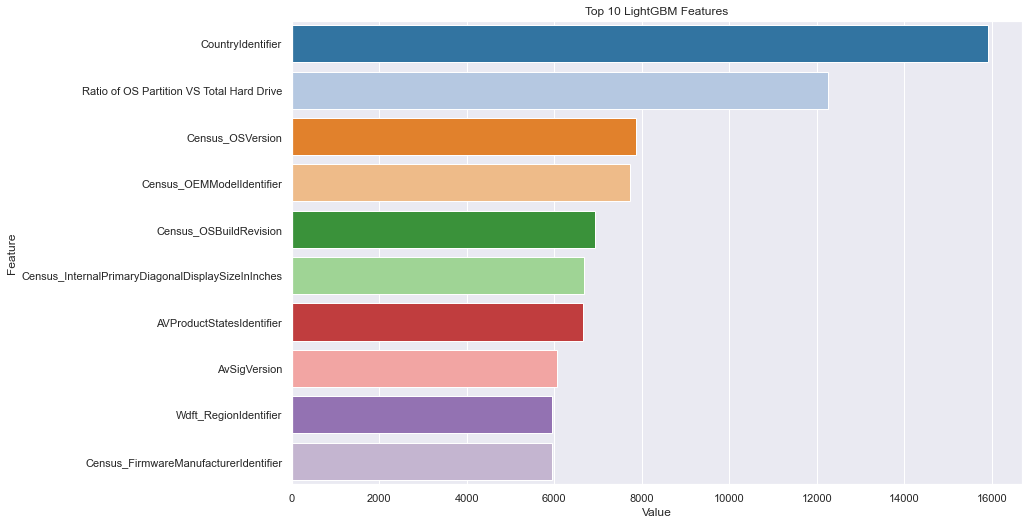

<Figure size 2498.4x2827.44 with 0 Axes>

In [115]:
plt.figure(figsize=(15, 8))
sns.barplot(x="Value", y="Feature", data=top10_feature_imp)
plt.title('Top 10 LightGBM Features')
plt.tight_layout()
plt.rcParams.update({'font.size': 30})
plt.show()
plt.savefig('Top 10 lgbm_importances-01.png')

In [157]:
## PREDICT on the test set provided by Microsoft

In [158]:
test_dtypes = {k: v for k, v in dtypes.items() if k in good_cols}

# get all columns except
df_test = pd.read_csv('data/microsoft-malware-prediction/test.csv', dtype=test_dtypes, usecols=good_cols[:-1])

In [159]:
df_test.shape

(7853253, 67)

In [160]:
# ENGINEERED FEATURE 1
df_test['AppVersion2'] = df_test['AppVersion'].map(lambda x: np.int(x.split('.')[1]))

# ENGINEERED FEATURE 2
df_test['DriveA'] = df_test['Census_SystemVolumeTotalCapacity'].astype('float')/df_test['Census_PrimaryDiskTotalCapacity'].astype('float')
df_test['DriveA'] = df_test['DriveA'].astype('float32')

# ENGINEERED FEATURE 3
new = df_test["OsBuildLab"].str.split(".", expand = True)
df_test["OsBuildLab1"] = new[2]


In [161]:
for column in df_test.columns:
    df_test[column].fillna(df_test[column].mode()[0], inplace=True)

In [162]:
df_test = df_test.drop(['OsBuild','Census_InternalPrimaryDisplayResolutionHorizontal', 'Census_OSInstallLanguageIdentifier',
                         'Census_ProcessorModelIdentifier', 'Census_TotalPhysicalRAM', 'GeoNameIdentifier' ],axis=1)

In [163]:
df_test = df_test.drop(['MachineIdentifier'], axis = 1)

In [164]:
df_test.shape

(7853253, 63)

In [165]:
MultiLabelEncoder(categorical_columns, df_test)

In [166]:
gc.collect()

123

In [2]:
df_test_sample = df_test.sample (n=100000)

In [ ]:
new_predict = (lgbmodel.predict_proba(df_test_sample)[:, 1] >= 0.2)